# Joint distribution estimation

The goal of this notebook is to investigate different approach to joint distribution estimation.

The most natural one is to use the empirical estimator of joint probability, resulting in the discrete case in an empirical co-observation matrix.
The problem however is that this matrix is typically very sparse, especially in the tails if there are too few observations. This is a critical issue when trying to model extreme events and tail dependencies.

A parametric approach consists of fitting a pre-determined copula to the observed data, for instance by plugging the empirical Kendall's $\tau$ and solving for the copula parameter that achieve this value of $\tau$. This is however sensitive to the choice of the pre-determined copula, leading to model misspecification risk.

We investigate approaches based on matrix completion, which implicitely assumes some level of smoothness in the joint distribution, i.e in the entries of the co-observation matrix.

In [1]:
from IPython.core.display import HTML
display(HTML('<style>.container { width:95% !important; } </style>'))

%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from scipy.stats import kendalltau
import matplotlib.pyplot as plt
import seaborn as sns
import sys

sys.path.insert(0, '../../')
from bivariate_copula import *

sns.set()

### Simulate Joint distribution

We use a certain copula to simulate a non-trivial dependency between variables.

In [3]:
sigma_x = 3.0
sigma_y = 1.0

# Sample a large number of points for ground truth...
N = int(5e4)
# ... but observe only the first few 
n_obs = 50

X = np.random.normal(0, sigma_x, size=N)
Y = np.random.normal(0, sigma_y, size=N)

mode = 'Clayton'

if mode == 'Gumbel':
    copula = GumbelCopula(X, Y)
elif mode == 'Clayton':
    copula = ClaytonCopula(X, Y)
elif mode == 'Gaussian':
    copula = GaussianCopula(X, Y)
    

theta = 3.0
copula.theta = theta
X_sim, Y_sim = copula.simulate(N)

# clip to get bounded data
box_x = 3 * sigma_x
box_y = 3 * sigma_y
X_sim = np.clip(X_sim, -box_x, box_x)
Y_sim = np.clip(Y_sim, -box_y, box_y)

### Kendall's tau and relation with $\theta$

In [4]:
def kendalltau_true(theta, mode='Gaussian'):
    if mode == 'Gumbel':
        return 1 - 1/ theta
    elif mode == 'Clayton':
        return theta / (theta + 2)
    elif mode == 'Gaussian':
        return 2 / np.pi * np.arcsin(theta)
    else:
        raise ValueError(mode)
        
def theta_from_tau(tau, mode='Gaussian'):
    if mode == 'Gumbel':
        return 1 / (1 - tau)
    elif mode == 'Clayton':
        return 2 * tau / (1 - tau)
    elif mode == 'Gaussian':
        return np.sin(np.pi * tau / 2)
    else:
        raise ValueError(mode)

In [5]:
tau_hat = kendalltau(X_sim[:n_obs], Y_sim[:n_obs]).correlation
print('Empirical tau : {:.0%} vs theoretical tau : {:.0%}'.format(tau_hat, kendalltau_true(theta, mode=mode)))

theta_hat = theta_from_tau(tau_hat, mode=mode)
print('Estimated theta : {:.2f} vs true theta : {:.2f}'.format(theta_hat, theta))

Empirical tau : 60% vs theoretical tau : 60%
Estimated theta : 3.04 vs true theta : 3.00


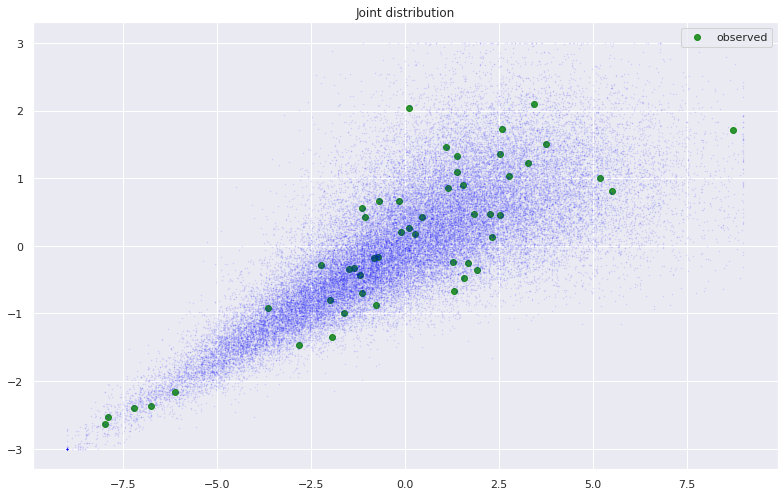

In [6]:
with sns.axes_style('darkgrid'):
    fig, ax = plt.subplots(figsize=(11, 7), nrows=1, ncols=1)

    ax.scatter(X_sim[:n_obs], Y_sim[:n_obs], label='observed', color='green', alpha=0.8)
    ax.scatter(X_sim[n_obs:], Y_sim[n_obs:], color='blue', alpha=0.1, s=0.3)

    ax.legend(loc='upper right')
    ax.title.set_text('Joint distribution')

    plt.tight_layout()
    plt.show()

### Discretize sampled data

To simulate discrete data, we bin the samples (as in a histogram).

In [7]:
n_bins_x = 10
n_bins_y = 7

H_ground_truth, _, _ = np.histogram2d(X_sim, Y_sim, bins=[n_bins_x, n_bins_y])
H_ground_truth /= N

H_obs, _, _ = np.histogram2d(X_sim[:n_obs], Y_sim[:n_obs], bins=[n_bins_x, n_bins_y])
H_obs /= n_obs

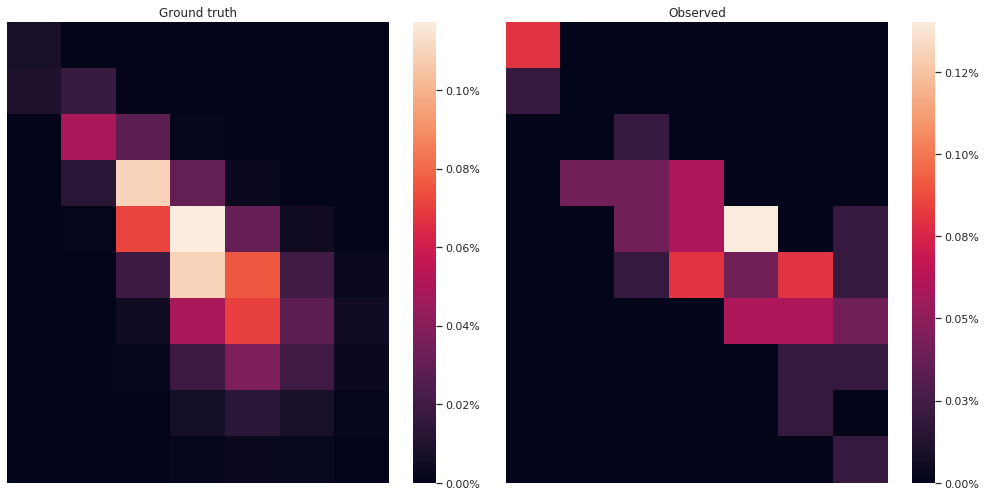

In [8]:
fig, axes = plt.subplots(figsize=(14, 7), nrows=1, ncols=2)

ax = axes[0]
sns.heatmap(H_ground_truth, ax=ax, cbar_kws={'format': '%.2f%%'}, xticklabels=[], yticklabels=[])
ax.set_title('Ground truth')

ax = axes[1]
sns.heatmap(H_obs, ax=ax, cbar_kws={'format': '%.2f%%'}, xticklabels=[], yticklabels=[])
ax.set_title('Observed')

plt.tight_layout()
plt.show()

### Estimate copula by fitting to Kendall's tau

Note that the type of copula used for estimation may be different than the one used for generating the data.
In real applications, the generative distribution is unknown, and one can only guess which type of copula is better suited.

In [9]:
estimation_mode = 'Gaussian'

theta_hat = theta_from_tau(tau_hat, mode=estimation_mode)
print('Copula for estimation : {} vs true copula : {}'.format(estimation_mode, mode))
print('Estimated theta : {:.2f} vs true theta : {:.2f}'.format(theta_hat, theta))

Copula for estimation : Gaussian vs true copula : Clayton
Estimated theta : 0.81 vs true theta : 3.00


In [10]:
# Use the chosen copula mode and the estimated parameter 
# to generate a large number of joint samples
# to serve as the ground truth for the estimated distribution.
if estimation_mode == 'Gumbel':
    estimation_copula = GumbelCopula(X, Y)
elif estimation_mode == 'Clayton':
    estimation_copula = ClaytonCopula(X, Y)
elif estimation_mode == 'Gaussian':
    estimation_copula = GaussianCopula(X, Y)
    
N_estimation_ = int(5e4)

estimation_copula.theta = theta_hat
X_estimation_, Y_estimation_ = estimation_copula.simulate(N_estimation_)

box_x = 3 * sigma_x
box_y = 3 * sigma_y
X_estimation_ = np.clip(X_estimation_, -box_x, box_x)
Y_estimation_ = np.clip(Y_estimation_, -box_y, box_y)

In [11]:
H_hat, _, _ = np.histogram2d(X_estimation_, Y_estimation_, bins=[n_bins_x, n_bins_y])
H_hat /= N_estimation_

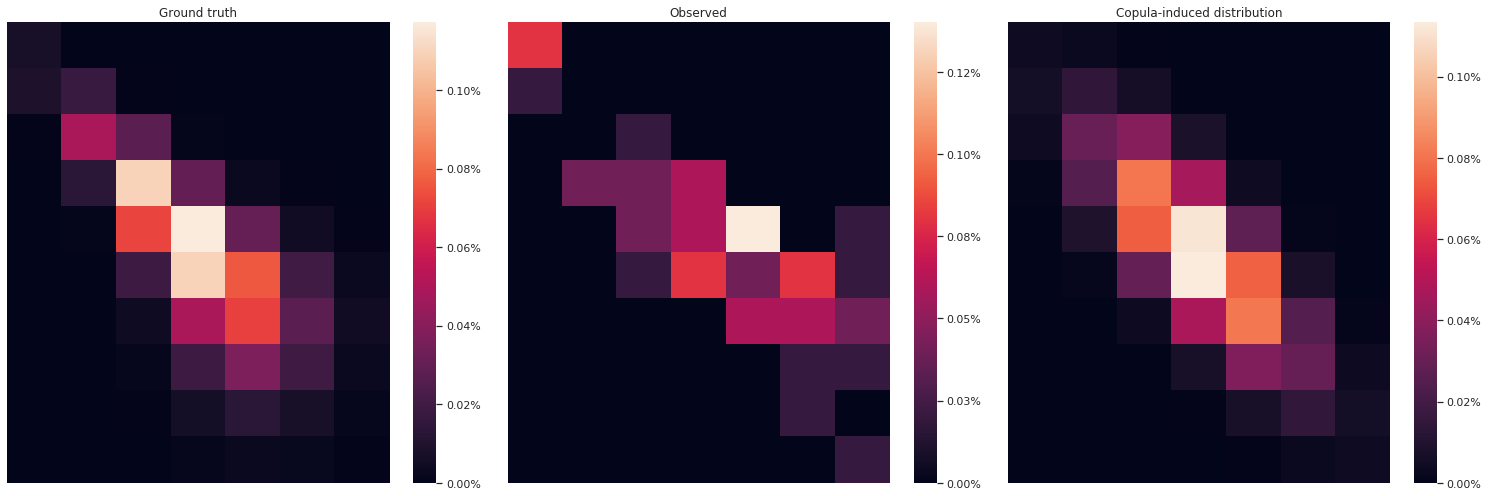

In [12]:
fig, axes = plt.subplots(figsize=(21, 7), nrows=1, ncols=3)

ax = axes[0]
sns.heatmap(H_ground_truth, ax=ax, cbar_kws={'format': '%.2f%%'}, xticklabels=[], yticklabels=[])
ax.set_title('Ground truth')

ax = axes[1]
sns.heatmap(H_obs, ax=ax, cbar_kws={'format': '%.2f%%'}, xticklabels=[], yticklabels=[])
ax.set_title('Observed')

ax = axes[2]
sns.heatmap(H_hat, ax=ax, cbar_kws={'format': '%.2f%%'}, xticklabels=[], yticklabels=[])
ax.set_title('Copula-induced distribution')

plt.tight_layout()
plt.show()

In [13]:
print('L1 matrix norm error: {:.4f}'.format(np.linalg.norm(H_hat - H_ground_truth, ord=1)))

L1 matrix norm error: 0.0619


### Conclusion: the parametric copula estimation is sensitive to the type of copula used.

For example if data are truly generated using a Clayton copula, estimating a Gaussian copula is prone to some model risk (typically the Gaussian estimation adapts to the strong left tail dependency of the Clayton copula by tuning a large Pearson correlation, but this creates also a right tail dependency which is absent from the Clayton copula). 
Note that in practice a way to mitigate that is to look at other metrics to guide the choice of the estimation copula (for instance the tail behaviour observed on data).

## Matrix completion approach

The problem with the empirical joint distribution matrix is that it is typically very sparse (few or even no observation in the bin corresponding to the tails).

One approach is to leverage matrix completion (à la Netflix Prize), for instance by looking for a low-rank matrix that is close to the original empirical matrix (typically in terms of Frobenius norm). This, as most combinatorial problem, is NP-hard but admits a tight convex relaxation by minimizing the nuclear norm $\lVert \cdot \rVert_*$ (sum of the singular values) instead of the rank.

### SVD

In [14]:
U, S, V = np.linalg.svd(H_obs, full_matrices=False)
assert np.allclose((U @ np.diag(S)) @ V, H_obs)

thresh = 0.3 * S[0]
S_thresh = np.maximum(S - thresh, 0)
H_complete = U @ np.diag(S_thresh) @ V

# (rough) projection on the simplex
H_complete = np.clip(H_complete, 0, 1)
H_complete /= np.sum(H_complete)

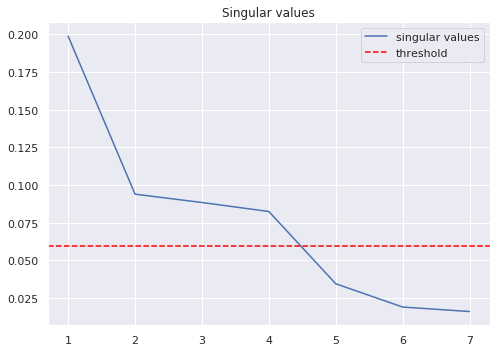

In [15]:
with sns.axes_style('darkgrid'):
    fig, ax = plt.subplots(figsize=(7, 5), nrows=1, ncols=1)
    
    ax.plot(np.linspace(1, len(S), len(S)), S, label='singular values')
    ax.axhline(y=thresh, linestyle='dashed', color='red', label='threshold')

    ax.title.set_text('Singular values')
    ax.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

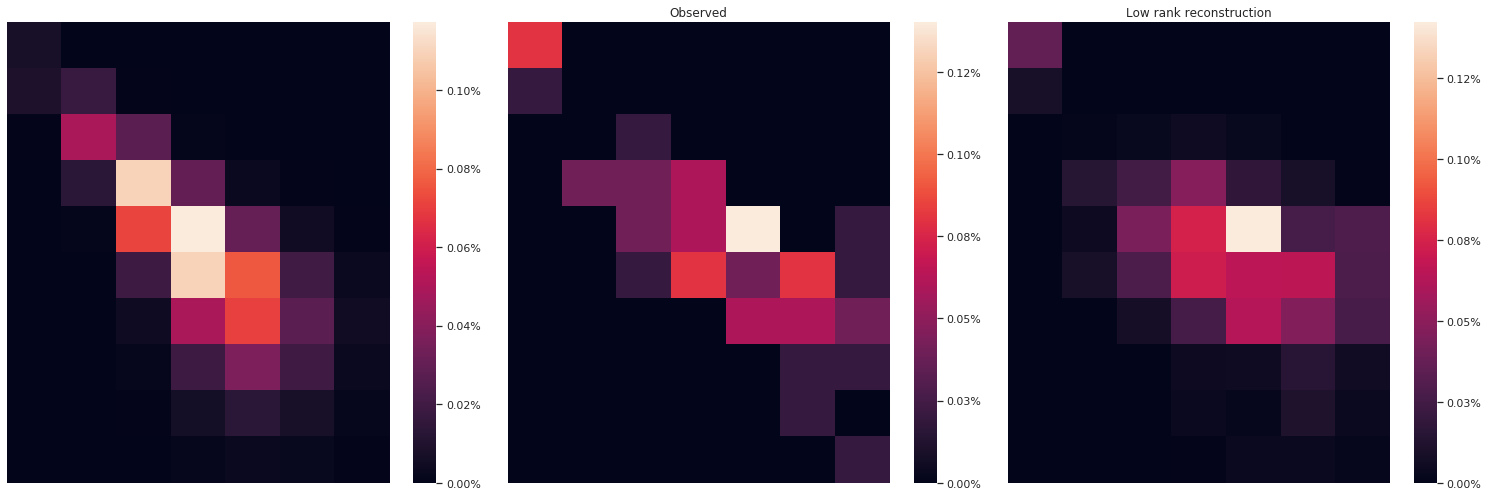

In [16]:
fig, axes = plt.subplots(figsize=(21, 7), nrows=1, ncols=3)

ax = axes[0]
sns.heatmap(H_ground_truth, ax=ax, cbar_kws={'format': '%.2f%%'}, xticklabels=[], yticklabels=[])

ax = axes[1]
sns.heatmap(H_obs, ax=ax, cbar_kws={'format': '%.2f%%'}, xticklabels=[], yticklabels=[])
ax.set_title('Observed')

ax = axes[2]
sns.heatmap(H_complete, ax=ax, cbar_kws={'format': '%.2f%%'}, xticklabels=[], yticklabels=[])
ax.set_title('Low rank reconstruction')

plt.tight_layout()
plt.show()

In [17]:
print('L1 matrix norm error: {:.4f}'.format(np.linalg.norm(H_complete - H_ground_truth, ord=1)))

L1 matrix norm error: 0.1904


### Matrix completion assuming distribution smoothness

Let's think of the co-observation matrix as a grid-like graph, i.e neighboring matrix entries are related in the graph. One may assume that the underlying joint distribution has some level of smoothness, indicated by the fact that nearby entries should be similar. This casts the problem of inferring the dependency structure as a semi-supervised learning (SSL) problem on a graph, where the goal is to learn a function from only a few observation and the assumption that the function varies slowly over related vertices.

Let $G=(V, E)$ a weighted undirected graph on $N=\lvert V\rvert$ vertices, $W$ its (weighted) adjacency matrix, $L$ its Laplacian.
Let $V_{obs}\subset V$ the subset of observed vertices (i.e those for which the corresponding entry in the co-observation matrix is nonnegative).
The SSL problem can be formulated as:

$$
\min_{f\in \mathbb{R}^N} \alpha\sum_{i\in V_{obs}} (f_i-y_i)^2 + \sum_{i,j} W_{ij}(f_i - f_j)^2
$$

i.e

$$
\min_{f\in \mathbb{R}^N} \alpha\sum_{i\in V_{obs}} (f_i-y_i)^2 + f^\top L f
$$

or even 

$$
\min_{f\in \mathbb{R}^N} \alpha\sum_{i\in V_{obs}} (f_i-y_i)^2 + f^\top (L+\gamma Id) f
$$

in the regularized form, with $\gamma>0$.

The first term corresponds to matching the observed entries (exact matching if $\alpha=\infty$, with the convention that $\infty \times 0 = 0$, which we will assume from now on). The second term is a smoothness term that penalizes graph functions $f$ that vary too brutally between too related vertices.

The solution is given by:

$f_{missing} = \big(L_{missing}+\gamma Id\big)^{-1} W_{missing, observed} f_{observed}$.

The parameter $\gamma$ is here to tune the amount of graph smoothness we impose in the solution : $\gamma\to \infty$ corresponds to to retrieving the observed matrix without smoothness.

In [18]:
import networkx as nx
G = nx.grid_2d_graph(n_bins_x, n_bins_y)
W = nx.adjacency_matrix(G).A
L = nx.laplacian_matrix(G).A

missing_x, missing_y = np.where(H_obs == 0)
observed_x, observed_y = np.where(H_obs > 0)
missing_flat_idx = missing_x * n_bins_y + missing_y
observed_flat_idx = observed_x * n_bins_y + observed_y

h_observed = H_obs.flatten()[observed_flat_idx]
W_missing_observed = W[np.ix_(missing_flat_idx, observed_flat_idx)]
L_missing = L[np.ix_(missing_flat_idx, missing_flat_idx)]

gamma = 5.0
h_missing = np.linalg.solve(L_missing + gamma * np.eye(len(missing_x)), W_missing_observed @ h_observed)

H_flat = H_obs.flatten()
H_flat[missing_flat_idx] = h_missing
H_hat_graph = H_flat.reshape((n_bins_x, n_bins_y))

# (rough) projection on the simplex
H_complete = np.clip(H_complete, 0, 1)
H_complete /= np.sum(H_complete)

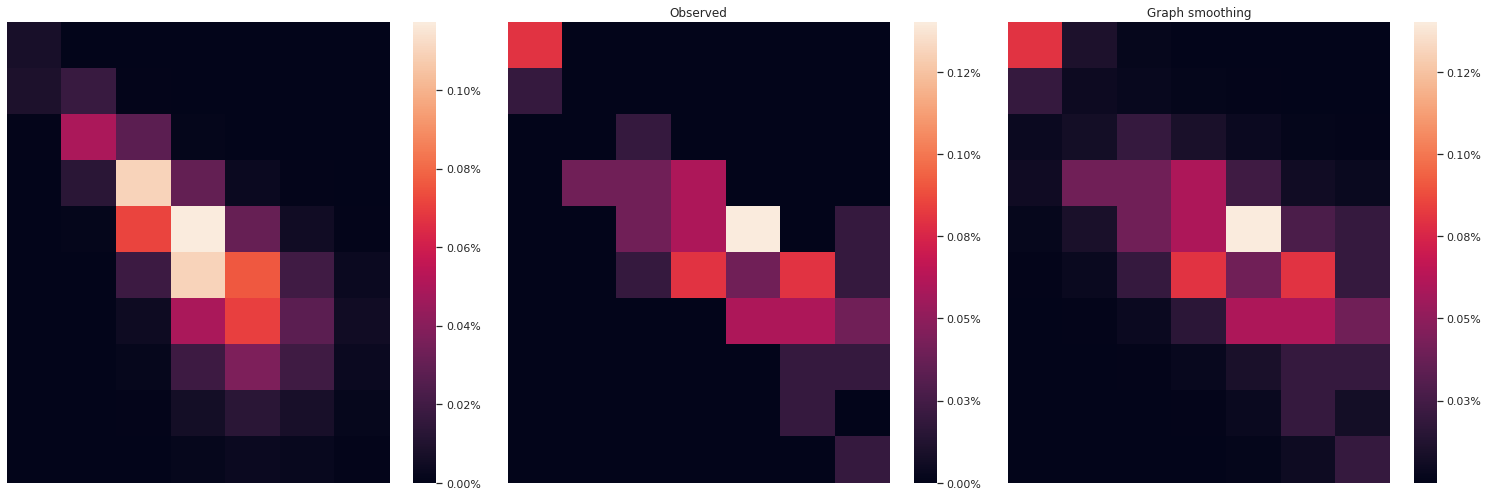

In [19]:
fig, axes = plt.subplots(figsize=(21, 7), nrows=1, ncols=3)

ax = axes[0]
sns.heatmap(H_ground_truth, ax=ax, cbar_kws={'format': '%.2f%%'}, xticklabels=[], yticklabels=[])

ax = axes[1]
sns.heatmap(H_obs, ax=ax, cbar_kws={'format': '%.2f%%'}, xticklabels=[], yticklabels=[])
ax.set_title('Observed')

ax = axes[2]
sns.heatmap(H_hat_graph, ax=ax, cbar_kws={'format': '%.2f%%'}, xticklabels=[], yticklabels=[])
ax.set_title('Graph smoothing')

plt.tight_layout()
plt.show()

In [20]:
print('L1 matrix norm error: {:.4f}'.format(np.linalg.norm(H_hat_graph - H_ground_truth, ord=1)))

L1 matrix norm error: 0.2200


The experiment is not really successful here, as the assumption that the co-observation matrix follows a strict grid-like pattern is not suited to the shape of the Clayton copula that was used to generate data (it tends to diffuse the mass that is concentrated near the diagonal). However, this formulation provides an extra degree of freedom in the weight matrix $W$ used to define the graph. A possible road to take for further investigation would be to use different weights $W$, i.e different graphs, and cast the user's prior on the joint distribution into the choice of $W$, the same way the choice of a copula class reflects a prior in the parametric setting.